<a href="https://colab.research.google.com/github/gabrielfernandorey/GGGR/blob/main/LSTM/SRT%20v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRT v5 - Ensayo
### LSTM - Nuevo Dataset

In [1]:
import random
import math
import string
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


### Importamos Datos

In [2]:
!wget https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/Regresion%20lineal/serie_acc_SRT.csv

--2023-05-07 23:37:46--  https://raw.githubusercontent.com/gabrielfernandorey/GGGR/main/Regresion%20lineal/serie_acc_SRT.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26984867 (26M) [text/plain]
Saving to: ‘serie_acc_SRT.csv.2’

serie_acc_SRT.csv.2 100%[===================>]  25.73M   156MB/s    in 0.2s    

2023-05-07 23:37:46 (156 MB/s) - ‘serie_acc_SRT.csv.2’ saved [26984867/26984867]



In [3]:
df = pd.read_csv('/content/serie_acc_SRT.csv', header=0, sep=';',
                 names=['año','mes','codigo','total_cp'],
                 dtype={'año': str, 'mes': str, 'codigo': str, 'total_cp': str})

In [4]:
column_order = ['codigo', 'año', 'mes', 'total_cp']
new_df = df.reindex(columns=column_order)
df = new_df.copy()

In [5]:
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


### EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470278 entries, 0 to 1470277
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   codigo    1469958 non-null  object
 1   año       1470278 non-null  object
 2   mes       1470278 non-null  object
 3   total_cp  1470278 non-null  object
dtypes: object(4)
memory usage: 44.9+ MB


#### Ajustamos tipo de datos

In [7]:
df['año'] = pd.to_numeric(df['año'], downcast='integer') #corregimos el formato de la columna 

In [8]:
df['mes'] = pd.to_numeric(df['mes']) #corregimos el formato de la columna 

In [9]:
df['total_cp'] = pd.to_numeric(df['total_cp']) #corregimos el formato de la columna 

In [10]:
df.dtypes

codigo      object
año          int16
mes          int64
total_cp     int64
dtype: object

In [11]:
df.head()

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1


### Eliminamos NaN

In [12]:
df = df.dropna(subset=['codigo'])
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


In [13]:
df = df.sort_values(['año','mes'], ascending=True)
df

,codigo,año,mes,total_cp
0,01657000,1995,1,1
1,08300000,1995,7,1
2,01900000,1995,9,1
3,01900000,1995,11,1
4,01650000,1996,3,1
...,...,...,...,...
1470273,05582000,2023,5,1
1470274,01754000,2023,5,7
1470275,03503000,2023,5,3
1470276,X5000FJA,2023,5,1


In [14]:
# Verificar cuantos registros tienen el codpos mayor a 8 caracteres
df_codigo = df.loc[df['codigo'].apply(lambda x: len(str(x)) > 8)]
df_codigo

,codigo,año,mes,total_cp


In [15]:
# Verificar cuantos registros tienen el codpos menor a 4 caracteres
df_codigo = df.loc[df['codigo'].apply(lambda x: len(str(x)) < 4)]
df_codigo

,codigo,año,mes,total_cp


### Convertimos el codigo postal a 4 caracteres

In [16]:
df.codigo = df['codigo'].str.slice(start=1, stop=5)
df

,codigo,año,mes,total_cp
0,1657,1995,1,1
1,8300,1995,7,1
2,1900,1995,9,1
3,1900,1995,11,1
4,1650,1996,3,1
...,...,...,...,...
1470273,5582,2023,5,1
1470274,1754,2023,5,7
1470275,3503,2023,5,3
1470276,5000,2023,5,1


#### Verificamos cantidad de registros por codigo

In [17]:
# codigos unicos
contador = df['codigo'].value_counts()
contador

5000    21916
2000    18100
4000    13459
5500    12482
1425    12020
        ...  
4361        1
6412        1
4677        1
5884        1
3033        1
Name: codigo, Length: 3355, dtype: int64

### Conservamos al menos 48 meses por codigo

In [18]:
periodo = 48

In [19]:
mayores_a_periodo = contador[contador > periodo]

In [20]:
len(mayores_a_periodo)

2195

In [21]:
df = df[df['codigo'].isin(mayores_a_periodo.index)]

In [22]:
df

,codigo,año,mes,total_cp
0,1657,1995,1,1
1,8300,1995,7,1
2,1900,1995,9,1
3,1900,1995,11,1
4,1650,1996,3,1
...,...,...,...,...
1470273,5582,2023,5,1
1470274,1754,2023,5,7
1470275,3503,2023,5,3
1470276,5000,2023,5,1


### Eliminamos códigos no válidos

In [23]:
df = df.loc[df.codigo != "    "]

In [24]:
df = df.loc[df.codigo != "   0"]

In [25]:
df = df.loc[df.codigo != "0000"]

In [26]:
df = df.loc[df.codigo != "0001"]

In [27]:
df = df.loc[df.codigo != "0005"]

### Transformacion

In [28]:
# Utilizamos la fecha como indice 
df['fecha'] = pd.to_datetime({'year': df['año'],
                               'month': df['mes'],
                               'day': '01'})
df

,codigo,año,mes,total_cp,fecha
0,1657,1995,1,1,1995-01-01
1,8300,1995,7,1,1995-07-01
2,1900,1995,9,1,1995-09-01
3,1900,1995,11,1,1995-11-01
4,1650,1996,3,1,1996-03-01
...,...,...,...,...,...
1470273,5582,2023,5,1,2023-05-01
1470274,1754,2023,5,7,2023-05-01
1470275,3503,2023,5,3,2023-05-01
1470276,5000,2023,5,1,2023-05-01


In [29]:
df = df.set_index('fecha')
df

,codigo,año,mes,total_cp
fecha,,,,
1995-01-01,1657,1995,1,1
1995-07-01,8300,1995,7,1
1995-09-01,1900,1995,9,1
1995-11-01,1900,1995,11,1
1996-03-01,1650,1996,3,1
...,...,...,...,...
2023-05-01,5582,2023,5,1
2023-05-01,1754,2023,5,7
2023-05-01,3503,2023,5,3


### Visualizacion

In [30]:
unicos = pd.unique(df.codigo)
unicos

array(['1657', '8300', '1900', ..., '8107', '5566', '8335'], dtype=object)

In [31]:
codigo_in = random.choice(unicos) 
codigo_in

'5900'

In [32]:
filtro = df[df.codigo == codigo_in]
filtro

,codigo,año,mes,total_cp
fecha,,,,
1997-06-01,5900,1997,6,1
1999-08-01,5900,1999,8,1
2002-01-01,5900,2002,1,1
2002-02-01,5900,2002,2,1
2002-08-01,5900,2002,8,1
...,...,...,...,...
2023-04-01,5900,2023,4,2
2023-04-01,5900,2023,4,1
2023-04-01,5900,2023,4,1


In [83]:
### *********** EL DATASET NO ESTA SUMARIZADO !!!! *******************

In [104]:
sumarizado = filtro.groupby(['año', 'mes'])['total_cp'].transform('sum').sort_index(ascending=True)
sumarizado

fecha
1997-06-01      1
1999-08-01      1
2002-01-01      1
2002-02-01      1
2002-08-01      1
             ... 
2023-04-01    119
2023-04-01    119
2023-04-01    119
2023-04-01    119
2023-05-01      5
Name: total_cp, Length: 2435, dtype: int64

In [106]:
idx = pd.Index(sumarizado)
nueva = idx.duplicated(keep='first')
nueva

array([False,  True,  True, ...,  True,  True,  True])

In [103]:
dr = sumarizado.duplicated(keep='first')
dr

fecha
1997-06-01    False
1999-08-01     True
2002-01-01     True
2002-02-01     True
2002-08-01     True
              ...  
2023-04-01     True
2023-04-01     True
2023-04-01     True
2023-04-01     True
2023-05-01     True
Name: total_cp, Length: 2435, dtype: bool

In [87]:
defi = pd.unique(new_filtro)
defi

array([  1,   2,   3,   5,   6,   4,   7,   9,  12,  13,  21,  16,  19,
        33,  27,  18,  25,  46,  29,  76, 116, 108, 109, 103,  97, 111,
       106,  88, 107, 126, 115, 137, 100, 123, 117, 136, 102,  89, 128,
       131,  80, 114, 134, 140, 152, 161, 130,  99, 139, 141, 168, 147,
       148, 146, 144, 149, 113, 172, 119, 135, 185, 124, 122, 132, 177,
       153, 158, 170, 142, 155, 125, 166, 164, 143, 169, 156, 129, 188,
       145, 181, 160,  96, 112,  92, 133, 127,  85,  93,  54,  59,  91,
       171,  98, 120, 163, 213, 179, 151])

In [34]:
filtro.tail(1).index[0]

Timestamp('2023-05-01 00:00:00')

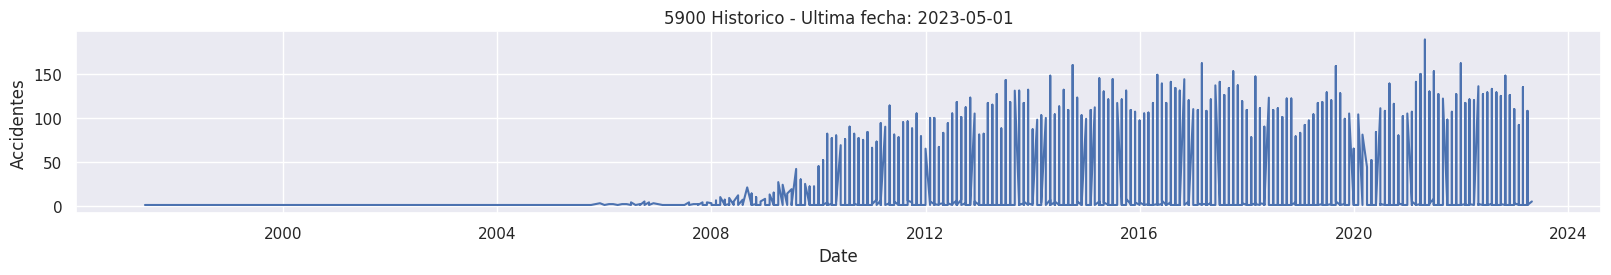

In [37]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico'+' - Ultima fecha: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(filtro['total_cp'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Preparamos datos

In [38]:
data = filtro.filter(['total_cp'])

In [39]:
# Convertimos a numpy array
dataset = data.values
len(dataset)

2435

### Transformar la variable de salida

In [40]:
mmscaler = MinMaxScaler()

In [41]:
data_scaled = mmscaler.fit_transform(dataset)

### Pre-entrenamiento

In [42]:
# Calculamos cantidad de datos para training y para test
training_data_len = math.ceil(len(dataset) * .8)
training_data_len 

1948

In [43]:
# Prepara datos de entrenamiento
train_data = data_scaled[0:training_data_len, : ]
len(train_data)

1948

In [44]:
X_train = []
y_train = []

for i in range(periodo, len(train_data)):
    X_train.append(train_data[i-periodo:i, 0])
    y_train.append(train_data[i, 0])


In [45]:
#Convertir a numpy
X_train, y_train = np.array(X_train), np.array(y_train)

In [46]:
X_train.shape

(1900, 48)

In [47]:
#Reshape 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1900, 48, 1)

### Modelo

In [65]:
dim_entrada = (X_train.shape[1], 1)  # dimension periodo
dim_salida = 1

modelo = Sequential()
modelo.add(LSTM(units=25, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

In [66]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 25)                2700      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [67]:
modelo.compile(optimizer='rmsprop', loss='mse')

In [68]:
modelo.fit(X_train, y_train, epochs=20, batch_size=16, )

Epoch 1/20
119/119 [==============================] - 6s 29ms/step - loss: 0.0199
Epoch 2/20
119/119 [==============================] - 3s 26ms/step - loss: 0.0197
Epoch 3/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0197
Epoch 4/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0197
Epoch 5/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0195
Epoch 6/20
119/119 [==============================] - 4s 30ms/step - loss: 0.0196
Epoch 7/20
119/119 [==============================] - 3s 25ms/step - loss: 0.0196
Epoch 8/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 9/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 10/20
119/119 [==============================] - 3s 25ms/step - loss: 0.0196
Epoch 11/20
119/119 [==============================] - 4s 31ms/step - loss: 0.0196
Epoch 12/20
119/119 [==============================] - 3s 23ms/step - loss: 0.0196
Epoch 13/20
1

### Prediccion

In [69]:
# Ultimos valores   del dataframe a array
last_days_scaled = data_scaled[-periodo:, : ]

In [70]:
len(data_scaled), len(last_days_scaled)

(2435, 48)

In [71]:
X_test_new = []
X_test_new.append(last_days_scaled)
X_test_new = np.array(X_test_new)
X_test_new = np.reshape(X_test_new, (1, periodo, 1))  # Entramos con un 1 vector de dimension 'periodo'

In [72]:
pred = modelo.predict(X_test_new)
pred = mmscaler.inverse_transform(pred)

1/1 [==============================] - 0s 455ms/step


In [73]:
print(f"Prediccion para el código {codigo_in} para la fecha {filtro.tail(1).index[0]}: {round(pred[0][0])} incidentes")  

Prediccion para el código 5900 para la fecha 2023-05-01 00:00:00: 10 incidentes


### Visualizar

In [74]:
X_test_new = np.reshape(X_test_new, (1, periodo))

In [75]:
last = mmscaler.inverse_transform(X_test_new)

In [76]:
df_incidentes = pd.DataFrame(last)

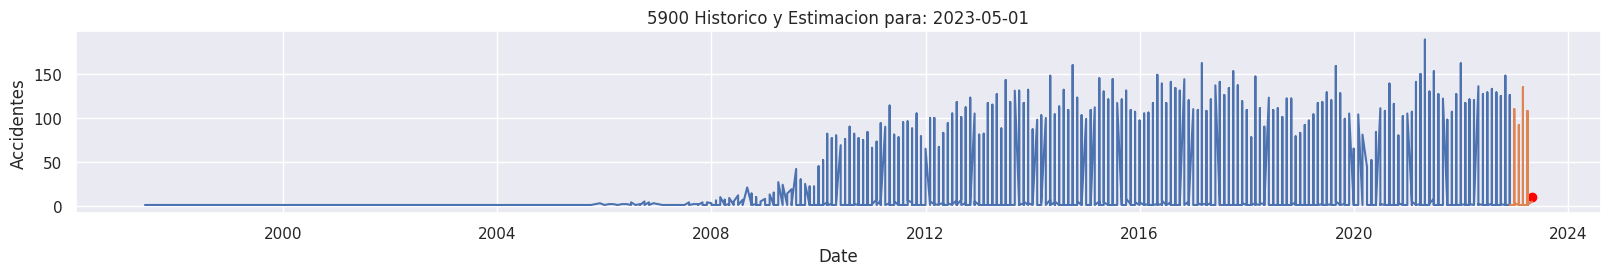

In [77]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico y Estimacion para: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(data[:-periodo])
plt.plot(data[-periodo:])
plt.scatter([filtro.tail(1).index[0]], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

In [79]:
# Ultimos incidentes
df_incidentes

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1.0,1.0,1.0,1.0,110.0,1.0,1.0,1.0,2.0,1.0,...,1.0,108.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0


In [82]:
data[-12:]

,total_cp
fecha,
2023-04-01,1
2023-04-01,1
2023-04-01,1
2023-04-01,108
2023-04-01,1
2023-04-01,1
2023-04-01,1
2023-04-01,2
2023-04-01,1


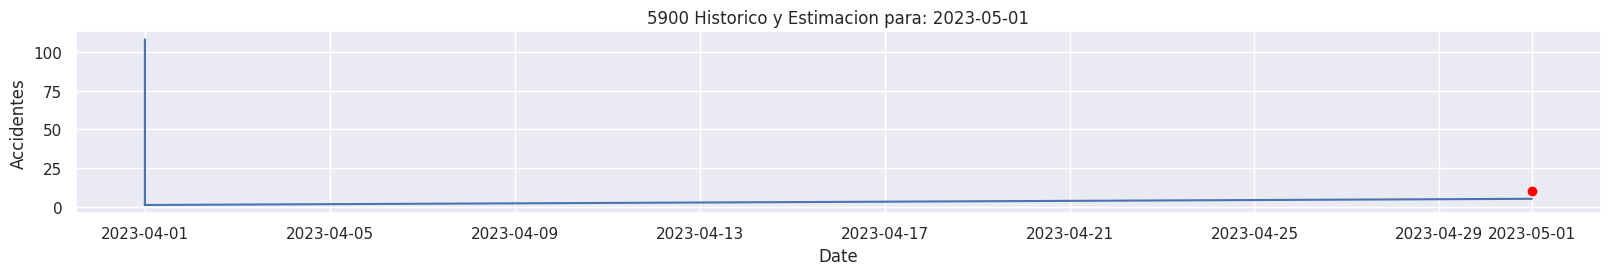

In [81]:
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Ultimos 12 meses y Estimacion para: '+ str(filtro.tail(1).index[0])[:10])
plt.plot(data[-12:])
plt.scatter([filtro.tail(1).index[0]], round(pred[0][0]), color='red')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12);

### Evaluacion para los proximos 6 meses

In [58]:
meses = 6

In [59]:
X_test_new.shape

(1, 48)

In [60]:
pred_m = []
X_test_actual = X_test_new
for m in range(meses):
  # Elimino el primer elemento
  X_test_proximo = np.delete(X_test_actual, 0, axis=1) 
  # Agregamos ultima prediccion
  X_test_proximo = np.append(X_test_proximo, round(pred[0][0]))
  # Transformo
  X_test_proximo = mmscaler.transform(X_test_proximo.reshape(-1, 1))
  X_test_proximo = np.reshape(X_test_proximo, (1, periodo, 1))  # Entramos con un 1 vector de dimension periodo
  pred = modelo.predict(X_test_proximo)
  pred = mmscaler.inverse_transform(pred)
  pred_m.append(round(pred[0][0]))
  X_test_actual = X_test_proximo


1/1 [==============================] - 0s 26ms/step


In [61]:
pred_m

[1, 1, 1, 1, 1, 1]

In [62]:
fechas = []
fechas = [filtro.tail(1).index[0] + pd.DateOffset(months=n) for n in range(meses) ]

In [63]:
estim = pd.DataFrame({'fecha':fechas, 'estimacion':pred_m}).set_index('fecha')
estim

,estimacion
fecha,
2023-04-01,1
2023-05-01,1
2023-06-01,1
2023-07-01,1
2023-08-01,1
2023-09-01,1


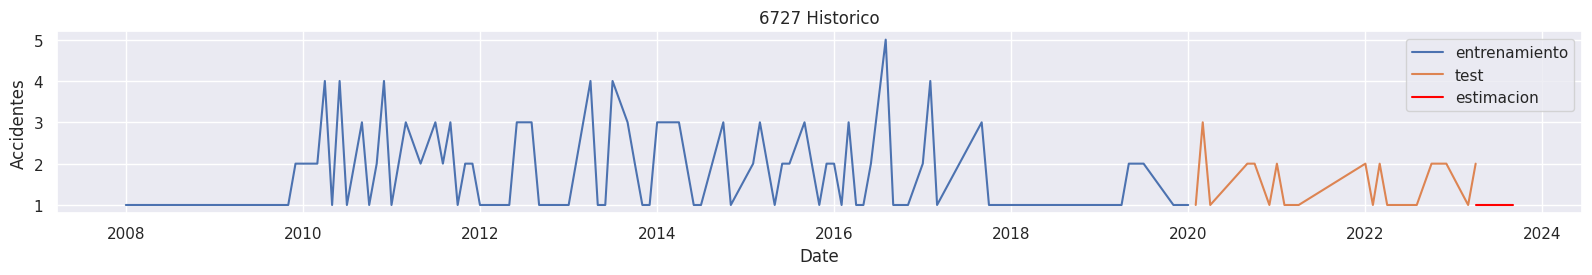

In [64]:
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(50*cm, 6*cm))
plt.title(str(codigo_in) +' Historico')
plt.plot(filtro['total_cp'][:training_data_len], label='entrenamiento')
plt.plot(filtro['total_cp'][training_data_len:], label='test')
plt.plot(estim['estimacion'],color='red', label='estimacion')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Accidentes', fontsize=12)
plt.legend();